above is test below orginal 

In [50]:
# ==================== Imports ====================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# ==================== Load Data ====================
file_path = r"C:\Users\Jitesh Makan\OneDrive\Desktop\toronto_airbnb_pricing_assistant\data\processed\listings_feature_matrix_Jitesh_ml.csv"
df = pd.read_csv(file_path)



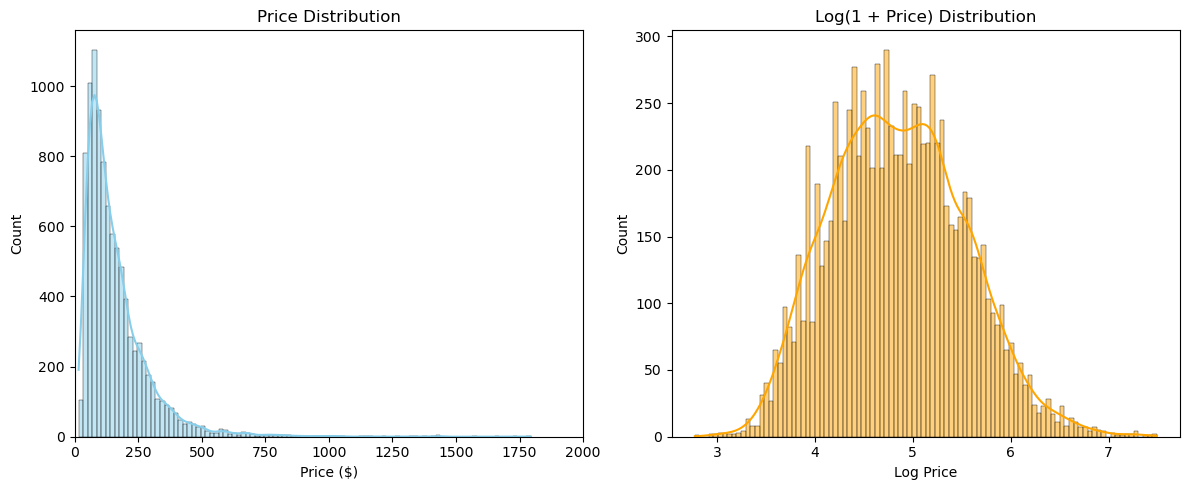

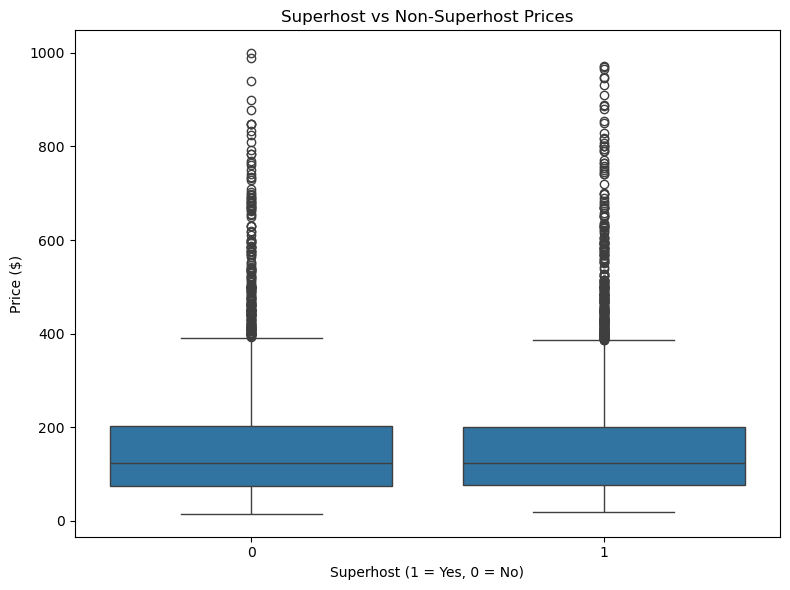

In [51]:
# ==================== Initial Visuals / EDA ====================
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['price'], bins=100, kde=True, color='skyblue')
plt.title("Price Distribution")
plt.xlabel("Price ($)")
plt.xlim(0, 2000)

plt.subplot(1, 2, 2)
sns.histplot(np.log1p(df['price']), bins=100, kde=True, color='orange')
plt.title("Log(1 + Price) Distribution")
plt.xlabel("Log Price")

plt.tight_layout()
plt.show()

if 'room_type' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='room_type', y='price', data=df[df['price'] < 1000])
    plt.title("Price by Room Type")
    plt.xlabel("Room Type")
    plt.ylabel("Price ($)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

if 'host_is_superhost' in df.columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='host_is_superhost', y='price', data=df[df['price'] < 1000])
    plt.title("Superhost vs Non-Superhost Prices")
    plt.xlabel("Superhost (1 = Yes, 0 = No)")
    plt.ylabel("Price ($)")
    plt.tight_layout()
    plt.show()



In [52]:
# ==================== Feature Engineering ====================
df['price_per_person'] = df['price'] / df['accommodates'].replace(0, np.nan)
df['bed_bath_interaction'] = df['bedrooms'] * df['bathrooms_count']
df['log_beds'] = np.log1p(df['beds'])
df['log_reviews_ly'] = np.log1p(df['number_of_reviews_ly'])

amenity_cols = [col for col in df.columns if col.startswith('amenities_')]
df['amenity_count'] = df[amenity_cols].sum(axis=1)
amenity_means = df[amenity_cols].mean()
common_amenities = amenity_means[amenity_means > 0.02].index.tolist()

base_features = [
    'accommodates', 'bedrooms', 'beds', 'bathrooms_count',
    'log_beds', 'log_reviews_ly', 'price_per_person',
    'bed_bath_interaction', 'amenity_count'
]
neighborhood_cols = [col for col in df.columns if col.startswith('neighbourhood_')]
property_type_cols = [col for col in df.columns if col.startswith('standardized_property_type')]
stay_duration_cols = ['stay_duration_Long-term', 'stay_duration_Mid-term', 'stay_duration_Short-term']

features = base_features + common_amenities + neighborhood_cols + property_type_cols + stay_duration_cols
target = np.log1p(df['price'])



In [ ]:
# ==================== Model Evaluation Function ====================
def evaluate_model(X, y, title="Model"):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestRegressor(n_estimators=500, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n\U0001F4CA {title} — R²: {r2_score(y_test, y_pred):.4f}")
    print(f"📉 Mean Absolute Error: {mean_absolute_error(y_test, y_pred):.4f}")
    print(f"📉 Mean Squared Error: {mean_squared_error(y_test, y_pred):.4f}")

    plt.figure(figsize=(6, 5))
    plt.scatter(y_test, y_pred, alpha=0.3, edgecolors='k')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual (log price)")
    plt.ylabel("Predicted (log price)")
    plt.title(f"Actual vs Predicted — {title}")
    plt.tight_layout()
    plt.show()

    return model

# ==================== Global Model ====================
print("\n\U0001F310 Global Model:")
X = df[features]
model = evaluate_model(X, target, title="Tuned Global Model")



🏡 Room Type: Entire home/apt (n=6542)

📊 Entire home/apt Model — R²: 0.9975
📉 Mean Absolute Error: 0.0079
📉 Mean Squared Error: 0.0009


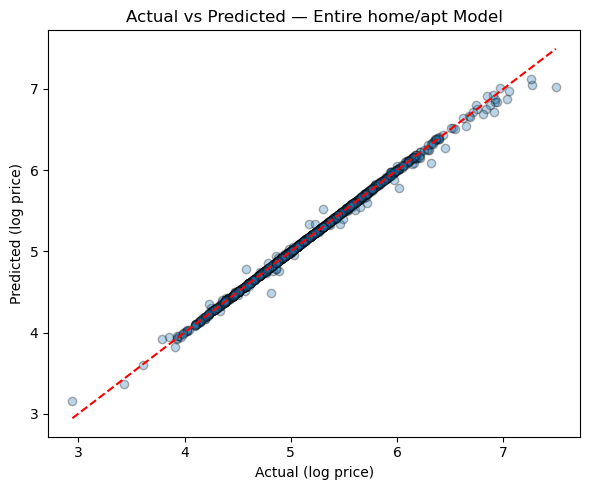


🏡 Room Type: Private room (n=3071)

📊 Private room Model — R²: 0.9866
📉 Mean Absolute Error: 0.0111
📉 Mean Squared Error: 0.0032


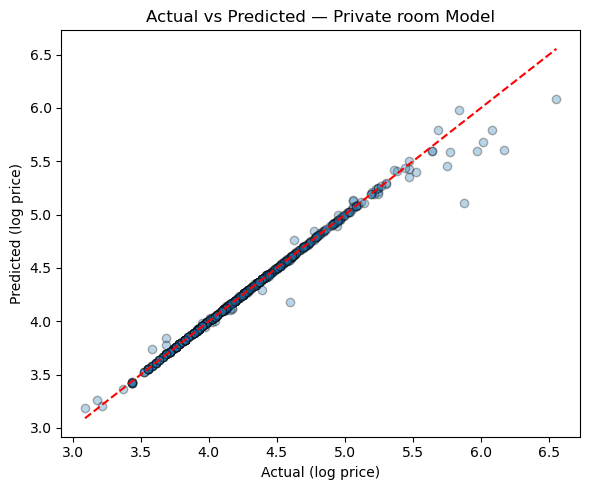


🏡 Room Type: Shared room (n=12)

📊 Shared room Model — R²: -0.4086
📉 Mean Absolute Error: 0.6499
📉 Mean Squared Error: 0.7105


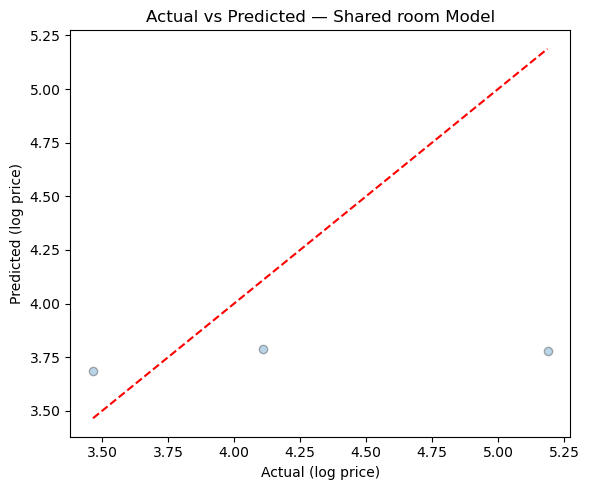

In [55]:
# ==================== Room Type Models ====================
room_types = ['Entire home/apt', 'Private room', 'Shared room']
for rt in room_types:
    col = f'room_type_{rt}'
    if col in df.columns:
        sub_df = df[df[col] == 1]
        print(f"\n\U0001F3E1 Room Type: {rt} (n={len(sub_df)})")
        X_sub = sub_df[features]
        y_sub = np.log1p(sub_df['price'])
        evaluate_model(X_sub, y_sub, title=f"{rt} Model")




🏘️ Property Type: standardized_property_type_apartment (n=4071)

📊 standardized_property_type_apartment Model — R²: 0.9944
📉 Mean Absolute Error: 0.0090
📉 Mean Squared Error: 0.0017


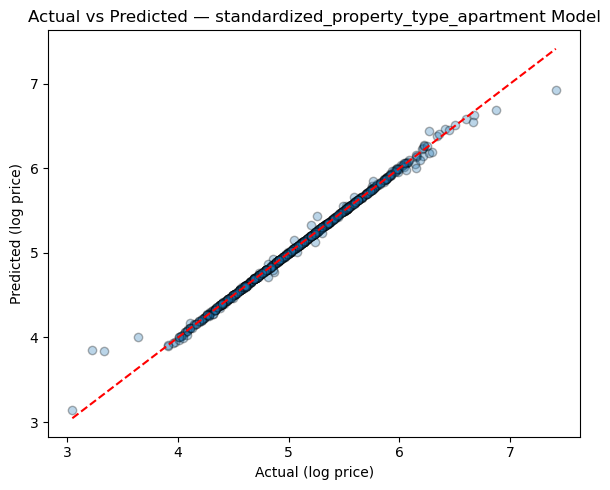


🏘️ Property Type: standardized_property_type_budget (n=3049)

📊 standardized_property_type_budget Model — R²: 0.9902
📉 Mean Absolute Error: 0.0078
📉 Mean Squared Error: 0.0020


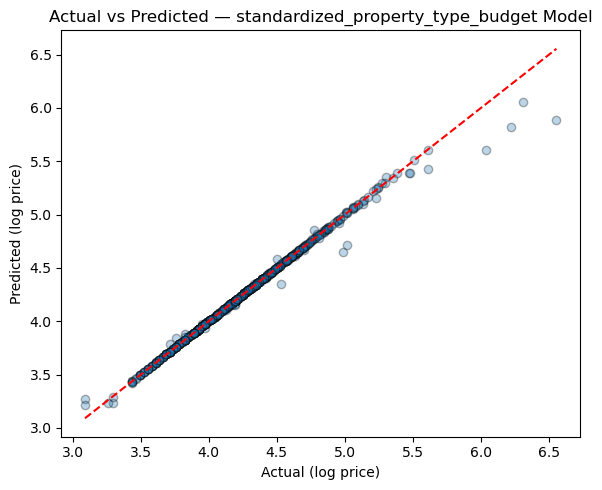


🏘️ Property Type: standardized_property_type_home (n=1873)

📊 standardized_property_type_home Model — R²: 0.9884
📉 Mean Absolute Error: 0.0297
📉 Mean Squared Error: 0.0048


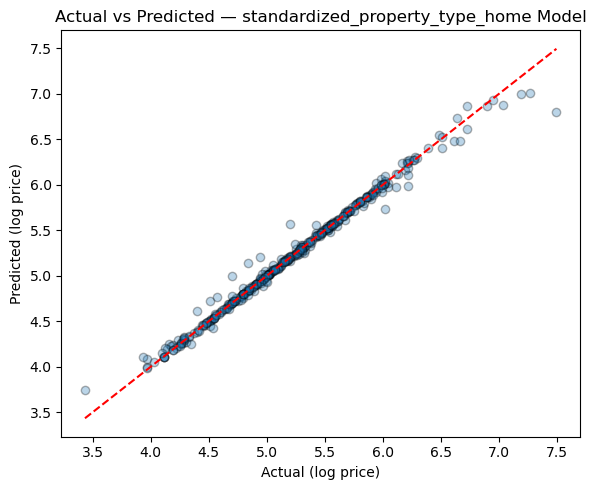


🏘️ Property Type: standardized_property_type_vacation (n=578)

📊 standardized_property_type_vacation Model — R²: 0.9450
📉 Mean Absolute Error: 0.0382
📉 Mean Squared Error: 0.0105


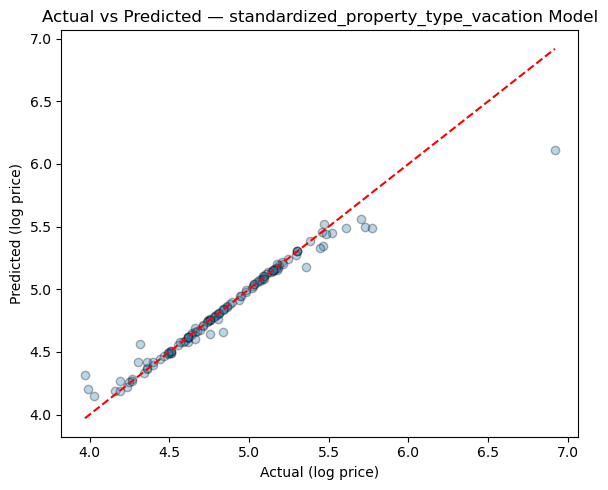

In [56]:
# ==================== Property Type Models ====================
for col in property_type_cols:
    sub_df = df[df[col] == 1]
    if len(sub_df) > 50:
        print(f"\n\U0001F3D8️ Property Type: {col} (n={len(sub_df)})")
        X_sub = sub_df[features]
        y_sub = np.log1p(sub_df['price'])
        evaluate_model(X_sub, y_sub, title=f"{col} Model")




🧑‍💼 Superhost Model (n=5581)

📊 Superhost Effect — R²: 0.9898
📉 Mean Absolute Error: 0.0137
📉 Mean Squared Error: 0.0048


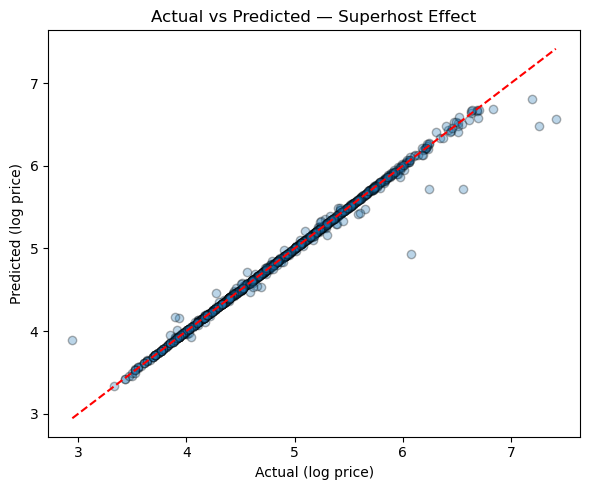

In [57]:
# ==================== Superhost Model ====================
if 'host_is_superhost' in df.columns:
    sub_df = df[df['host_is_superhost'] == 1]
    print(f"\n\U0001F9D1‍\U0001F4BC Superhost Model (n={len(sub_df)})")
    X_sub = sub_df[features]
    y_sub = np.log1p(sub_df['price'])
    evaluate_model(X_sub, y_sub, title="Superhost Effect")



💰 Estimated Revenue Model:

📊 Revenue Prediction — R²: 0.7319
📉 Mean Absolute Error: 0.3966
📉 Mean Squared Error: 0.3334


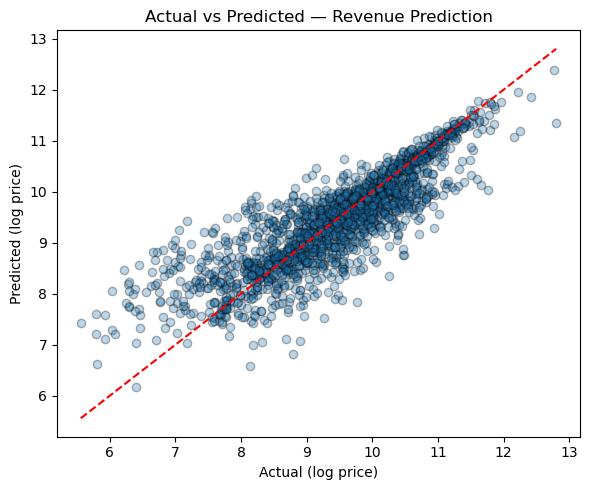

In [58]:

# ==================== Revenue Model ====================
if 'estimated_occupancy_l365d' in df.columns:
    df['estimated_revenue_l365d'] = df['price'] * df['estimated_occupancy_l365d']
    revenue_target = np.log1p(df['estimated_revenue_l365d'])
    print("\n\U0001F4B0 Estimated Revenue Model:")
    evaluate_model(X, revenue_target, title="Revenue Prediction")



C:\Users\Jitesh Makan\AppData\Local\Temp\ipykernel_26136\3637937051.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_amenities, x='importance', y='feature', palette='viridis')


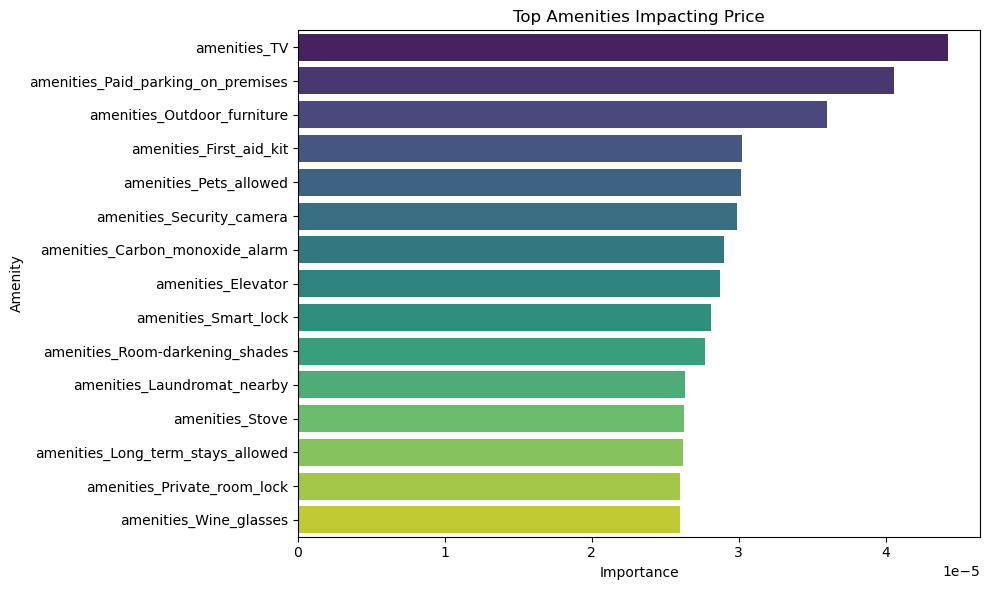

In [59]:
# ==================== Post-Model Visuals ====================
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

top_amenities = feature_importance_df[feature_importance_df['feature'].str.startswith('amenities_')].head(15)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_amenities, x='importance', y='feature', palette='viridis')
plt.title("Top Amenities Impacting Price")
plt.xlabel("Importance")
plt.ylabel("Amenity")
plt.tight_layout()
plt.show()

if 'estimated_revenue_l365d' in df.columns and 'room_type' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='room_type', y='estimated_revenue_l365d', data=df[df['estimated_revenue_l365d'] < 100000])
    plt.title("Estimated Revenue by Room Type")
    plt.xlabel("Room Type")
    plt.ylabel("Estimated Revenue ($)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
